In [52]:
import json
from pathlib import Path

import numpy as np

from qoc_common_crab import (
    load_baseline_crab,
    controls_from_coeffs,
    terminal_cost_and_grad_crab,
)

arrays, policy = load_baseline_crab("outputs/_baseline_crab")

t = arrays["t"]
dt = float(arrays["dt"])
T = float(arrays["T"])
Nt = arrays["Nt"]
Omega0 = arrays["Omega0"]
Delta0 = arrays["Delta0"]
basis_omega = arrays["CRAB_BASIS_OMEGA"]
basis_delta = arrays["CRAB_BASIS_DELTA"]
modes_omega = arrays["CRAB_MODES_OMEGA"]
modes_delta = arrays["CRAB_MODES_DELTA"]
rho0 = arrays["rho0"]
target = arrays["target"]
SEED = arrays["SEED"]

penalty_cfg = policy.get("penalties", {})
power_weight = float(penalty_cfg.get("power_weight", 0.0))
neg_weight = float(penalty_cfg.get("neg_weight", 0.0))
neg_kappa = float(penalty_cfg.get("neg_kappa", 10.0))

max_iters = policy.get("stopping", {}).get("max_iters_grape", 2000)
target_cost = policy.get("stopping", {}).get("target_cost", 1e-6)
max_calls = policy.get("stopping", {}).get("max_oracle_calls", 100000)

ls_defaults = {"alpha0": 5.0, "beta": 0.95, "c1": 0e-4, "max_backtracks": 100}
ls_defaults.update(policy.get("defaults", {}).get("crab", {}).get("ls", {}))

print(
    f"Loaded CRAB baseline. Nt={Nt}, dt={dt*1e3:.3f} ns | modes Omega={basis_omega.shape[1]}, Delta={basis_delta.shape[1]}\n"
    f"Penalties: power_weight={power_weight:g}, neg_weight={neg_weight:g}, neg_kappa={neg_kappa:g}"
)


Loaded CRAB baseline. Nt=201, dt=0.500 ns | modes Omega=3, Delta=3
Penalties: power_weight=5e-05, neg_weight=1, neg_kappa=1


In [53]:
import time

def grape_crab_linesearch(
    coeffs_Omega0,
    coeffs_Delta0,
    iters,
    alpha0,
    beta,
    c1,
    max_backtracks,
    *,
    power_weight,
    neg_weight,
    neg_kappa,
    target_cost=None,
    max_calls=None,
    log_every=200,
):
    coeffs_Omega = coeffs_Omega0.astype(float).copy()
    coeffs_Delta = coeffs_Delta0.astype(float).copy()
    costs = []
    times = []
    cost_terms = {"infidelity": [], "power": [], "neg": []}
    oracle_calls = 0
    t0 = time.time()
    Omega_last, Delta_last = controls_from_coeffs(
        coeffs_Omega,
        coeffs_Delta,
        Omega0,
        Delta0,
        basis_omega,
        basis_delta,
    )

    for k in range(iters):
        cost, gO, gD, Omega_eval, Delta_eval = terminal_cost_and_grad_crab(
            coeffs_Omega,
            coeffs_Delta,
            Omega0,
            Delta0,
            basis_omega,
            basis_delta,
            rho0,
            dt,
            target,
            power_weight=power_weight,
            neg_kappa=neg_kappa,
            neg_weight=neg_weight,
        )
        fluence = float(np.sum(Omega_eval * Omega_eval, dtype=float) * dt)
        penalty_power = 0.5 * power_weight * fluence
        if neg_weight > 0.0:
            neg = np.logaddexp(0.0, -neg_kappa * Omega_eval) / neg_kappa
            penalty_neg = 0.5 * neg_weight * float(np.sum(neg * neg, dtype=float) * dt)
        else:
            penalty_neg = 0.0
        base_cost = cost - penalty_power - penalty_neg

        costs.append(cost)
        times.append(time.time() - t0)
        cost_terms["infidelity"].append(base_cost)
        cost_terms["power"].append(penalty_power)
        cost_terms["neg"].append(penalty_neg)
        oracle_calls += 2

        grad_norm_sq = float(np.dot(gO, gO) + np.dot(gD, gD))
        if grad_norm_sq < 1e-16:
            break
        dir_O = -gO
        dir_D = -gD
        directional_derivative = -grad_norm_sq
        step = float(alpha0)
        accepted = False
        backtracks = 0
        while backtracks < max_backtracks:
            trial_coeffs_Omega = coeffs_Omega + step * dir_O
            trial_coeffs_Delta = coeffs_Delta + step * dir_D
            trial_cost, trial_gO, trial_gD, trial_Omega, trial_Delta = terminal_cost_and_grad_crab(
                trial_coeffs_Omega,
                trial_coeffs_Delta,
                Omega0,
                Delta0,
                basis_omega,
                basis_delta,
                rho0,
                dt,
                target,
                power_weight=power_weight,
                neg_kappa=neg_kappa,
                neg_weight=neg_weight,
            )
            oracle_calls += 2
            if trial_cost <= cost + c1 * step * directional_derivative:
                coeffs_Omega = trial_coeffs_Omega
                coeffs_Delta = trial_coeffs_Delta
                Omega_eval = trial_Omega
                Delta_eval = trial_Delta
                gO = trial_gO
                gD = trial_gD
                cost = trial_cost
                accepted = True
                break
            step *= beta
            backtracks += 1

        if not accepted:
            print("[WARN] Line search failed to satisfy Armijo condition; stopping.")
            break
        Omega_last, Delta_last = controls_from_coeffs(
            coeffs_Omega,
            coeffs_Delta,
            Omega0,
            Delta0,
            basis_omega,
            basis_delta,
        )

        if (k + 1) % max(1, log_every) == 0:
            print(f"[CRAB-LS] {k+1}/{iters}  C={cost:.3e}  calls={oracle_calls}")

        if (target_cost is not None and cost <= target_cost) or (
            max_calls is not None and oracle_calls >= max_calls
        ):
            break

    terms_arrays = {key: np.asarray(vals, dtype=float) for key, vals in cost_terms.items()}
    return (
        coeffs_Omega,
        coeffs_Delta,
        Omega_last,
        Delta_last,
        np.asarray(costs),
        np.asarray(times),
        oracle_calls,
        terms_arrays,
    )


[WARN] Line search failed to satisfy Armijo condition; stopping.


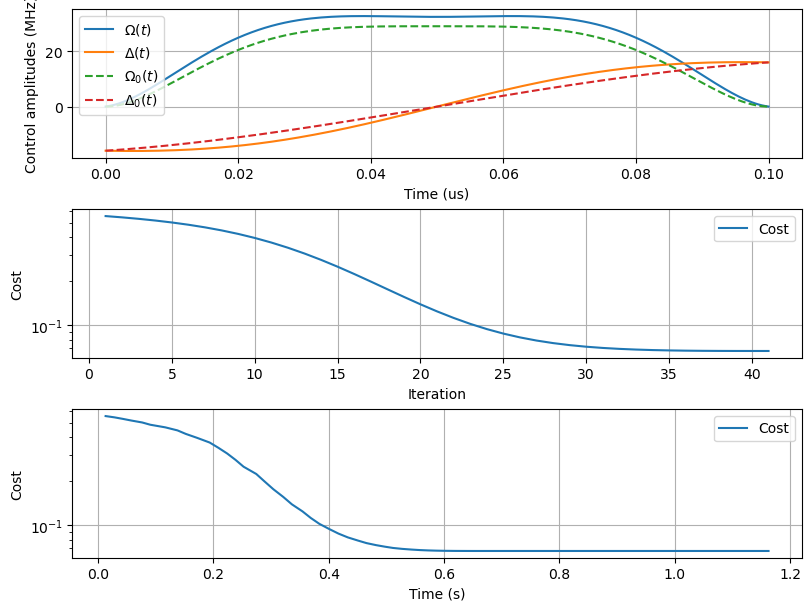

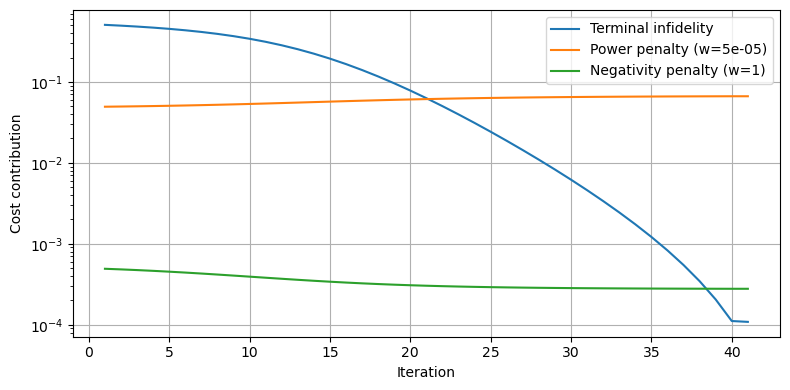

In [54]:
coeffs_O0 = np.zeros(basis_omega.shape[1], dtype=float)
coeffs_D0 = np.zeros(basis_delta.shape[1], dtype=float)

(
    coeffs_O_opt,
    coeffs_D_opt,
    Omega_opt,
    Delta_opt,
    cost_hist,
    times_s,
    oracle_calls,
    cost_terms,
) = grape_crab_linesearch(
    coeffs_O0,
    coeffs_D0,
    iters=max_iters,
    alpha0=float(ls_defaults.get("alpha0", 1.0)),
    beta=float(ls_defaults.get("beta", 0.6)),
    c1=float(ls_defaults.get("c1", 1e-4)),
    max_backtracks=int(ls_defaults.get("max_backtracks", 20)),
    power_weight=power_weight,
    neg_weight=neg_weight,
    neg_kappa=neg_kappa,
    target_cost=target_cost,
    max_calls=max_calls,
    log_every=200,
)

fluence_final = float(np.sum(Omega_opt * Omega_opt, dtype=float) * dt)
OUT = Path("outputs/terminal_crab/grape_linesearch")
OUT.mkdir(parents=True, exist_ok=True)

np.savez_compressed(
    OUT / "arrays.npz",
    t=t,
    dt=dt,
    Omega=Omega_opt,
    Delta=Delta_opt,
    coeffs_Omega=coeffs_O_opt,
    coeffs_Delta=coeffs_D_opt,
    basis_omega=basis_omega,
    basis_delta=basis_delta,
    cost_hist=cost_hist,
    times_s=times_s,
    cost_terms_infidelity=cost_terms["infidelity"],
    cost_terms_power=cost_terms["power"],
    cost_terms_neg=cost_terms["neg"],
)

metadata = {
    "method": "CRAB-LS",
    "cost_type": "TERMINAL",
    "seed": int(SEED),
    "oracle_calls": int(oracle_calls),
    "hyperparams": {
        "alpha0": float(ls_defaults.get("alpha0", 1.0)),
        "beta": float(ls_defaults.get("beta", 0.6)),
        "c1": float(ls_defaults.get("c1", 1e-4)),
        "max_backtracks": int(ls_defaults.get("max_backtracks", 20)),
    },
    "penalties": {
        "power_weight": float(power_weight),
        "neg_weight": float(neg_weight),
        "neg_kappa": float(neg_kappa),
    },
    "summary": {
        "fluence_Omega": fluence_final,
        "terminal_infidelity_final": float(cost_terms["infidelity"][-1]),
        "power_penalty_final": float(cost_terms["power"][-1]),
        "neg_penalty_final": float(cost_terms["neg"][-1]),
    },
}

with open(OUT / "metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 6), layout="constrained")
axs[0].plot(t, Omega_opt / (2 * np.pi), label=r"$\Omega(t)$")
axs[0].plot(t, Delta_opt / (2 * np.pi), label=r"$\Delta(t)$")
axs[0].plot(t, Omega0 / (2 * np.pi), "--", label=r"$\Omega_0(t)$")
axs[0].plot(t, Delta0 / (2 * np.pi), "--", label=r"$\Delta_0(t)$")
axs[0].set_xlabel("Time (us)")
axs[0].set_ylabel("Control amplitudes (MHz)")
axs[0].legend()
axs[0].grid(True)

axs[1].semilogy(np.arange(1, len(cost_hist) + 1), cost_hist, label="Cost")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Cost")
axs[1].grid(True)
axs[1].legend()

axs[2].semilogy(times_s, cost_hist, label="Cost")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Cost")
axs[2].grid(True)
axs[2].legend()

iters = np.arange(1, cost_hist.size + 1)
plt.figure(figsize=(8, 4))
plt.semilogy(iters, cost_terms["infidelity"], label="Terminal infidelity")
if power_weight > 0.0 and np.any(cost_terms["power"] > 0):
    plt.semilogy(iters, cost_terms["power"], label=f"Power penalty (w={power_weight:g})")
if neg_weight > 0.0 and np.any(cost_terms["neg"] > 0):
    plt.semilogy(iters, cost_terms["neg"], label=f"Negativity penalty (w={neg_weight:g})")
plt.xlabel("Iteration")
plt.ylabel("Cost contribution")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()
